# Multi Axion System

In [46]:
%run observables.py
%run multi_axion.py
%run analysis_tools.py
%run plot_tools.py

def sim_multi_axion(Q, Lambda, thetas0, H_inf=1e8, Gamma_inf=1e8, tmax_axion=8e2, save=False, velocities=None):
    energy_scale, conv_factor, rho_R_init, rho_inf_init, scale, tmax_inf, red_chem_pots_init = \
        init_system(H_inf, Gamma_inf, (Q, Lambda), multi_axion_field, tmax_axion)
    rh_sol, T_and_H_fn, T_and_H_and_T_dot_fn = decay_process.solve(tmax_inf, rho_R_init, rho_inf_init, scale, Gamma_inf)
    
    u0 = np.hstack([thetas0, np.zeros(len(Lambda)) if velocities is None else velocities])
    axsol = multi_axion_field.solve(u0, (Q, Lambda), tmax_axion, T_and_H_fn, Gamma_inf)
    
    ts = np.geomspace(axsol.t[1], axsol.t[-1], 500)
    theta1s, theta2s, theta1_dots, theta2_dots = canoncial_states = axsol.sol(ts)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(ts, theta1s, label=canonical_names[0])
    ax1.plot(ts, theta2s, label=canonical_names[1])
    ax1.set_xscale("log")
    ax1.set_xlabel(r"$m_a \cdot t$")
    ax1.legend()
    ax2.plot(ts, theta1_dots, label=canonical_names[2])
    ax2.plot(ts, theta2_dots, label=canonical_names[3])
    ax2.set_xscale("log")
    ax2.set_xlabel(r"$m_a \cdot t$")
    ax2.legend()
    if save: plt.savefig(os.path.join(plotpath, "multi_axion_canonical_field_evolution.pdf"), bbox_inches="tight")

    interval = np.pi / 8 
    def calc_range(x): return np.linspace(np.floor(np.min(x) / interval) * interval, np.ceil(np.max(x) / interval) * interval, 100)
    range1, range2 = calc_range(theta1s), calc_range(theta2s)
    V = np.array([[multi_axion_field.calc_V([t1, t2], Q, Lambda) for t1 in range1] for t2 in range2])

    plt.figure(figsize=(6,5))
    plt.contourf(range1, range2, V, levels=15)
    plt.plot(theta1s, theta2s, color="red")
    plt.plot([theta1s[0]], [theta2s[0]], "bo")
    plt.xlabel(r"$\theta_1$")
    plt.ylabel(r"$\theta_2$")
    plt.colorbar(label=r"$V(\theta_1, \theta_2)$")
    if save: plt.savefig(os.path.join(plotpath, "multi_axion_canonical_configspace.pdf"), bbox_inches="tight")

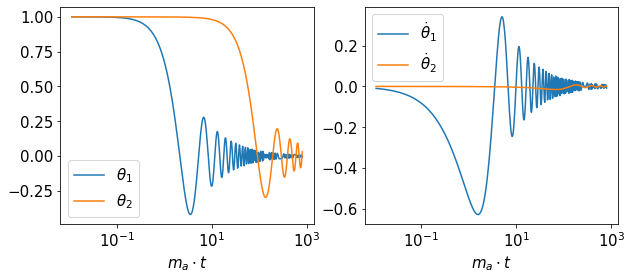

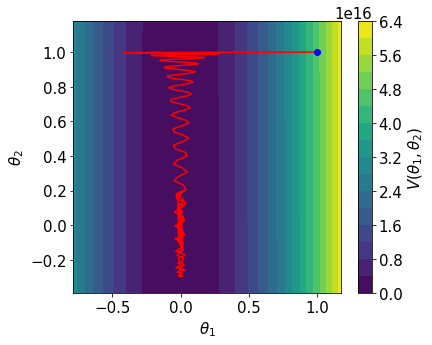

In [47]:
sim_multi_axion(np.array([[1,1], [1, 0]]), 1e7**2 * np.array([1, 1e3]), [1, 1])

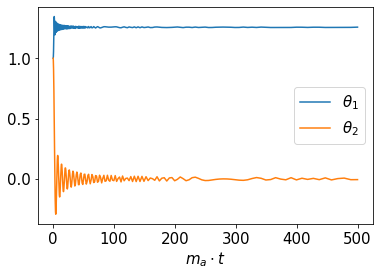

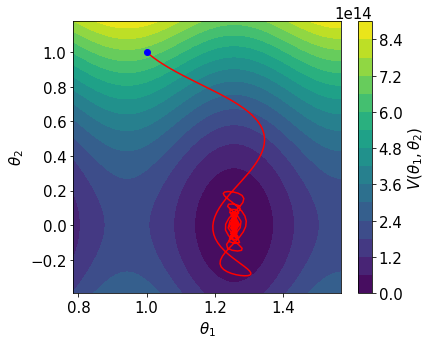

In [24]:
sim_multi_axion(np.array([[10,0], [0, 1]]), 1e7**2 * np.array([1, 1 + 10]), [1, 1], tmax_axion=5e2)

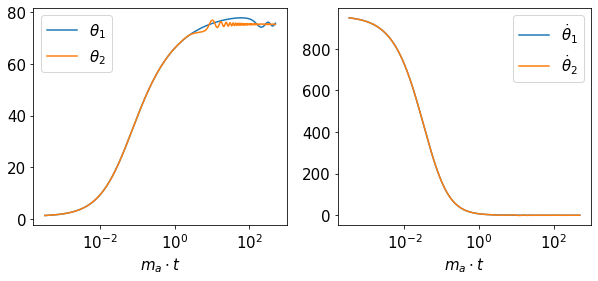

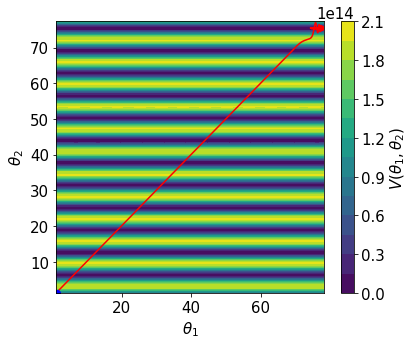

In [52]:
theta_i = 1
v = 1e3 * np.sqrt(2*(1 - np.cos(theta_i)))
sim_multi_axion(np.array([[1, 1], [0, 1]]), 1e7**2 * np.array([1e-3, 1]), [theta_i, theta_i], tmax_axion=5e2, velocities=[v, v])